Попробуйте обучить нейронную сеть LSTM на датасете  airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

******************

In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Conv1D, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = pd.read_csv('airline-passengers.csv')

In [4]:
date_split = data['Month'].str.split("-", expand=True)
data.drop(columns='Month', inplace=True)
data['Year'] = date_split[0]
data['Month'] = date_split[1]
target = 'Passengers'
feat = ['Year','Month']
data.head(2)


,Passengers,Year,Month
0,112,1949,01
1,118,1949,02


In [5]:
scaler = StandardScaler()
data[feat] = scaler.fit_transform(data[feat])
data.head(2)

,Passengers,Year,Month
0,112,-1.593255,-1.593255
1,118,-1.593255,-1.303572


In [6]:
# params 

batch_size = 24
epochs = 125
train_month = 120 # длина ттренфф
test_month = len(data) - train_month
future = 1 # горизонт предсказания
x_len = 7 # длина истории
bias = x_len + future

In [7]:
# data split
X_train = data[feat][:train_month].values
y_train = data[bias:train_month+bias][target].values
X_test = data[feat][train_month-bias:].values
y_test = data[train_month:][target].values

In [8]:
# Используем механизм формирования пакетов для обучения

dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [9]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (24, 7, 2)
Target shape: (24,)


***********************************

In [10]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Conv1D(64, 5, activation='linear'))
model.add(Conv1D(32, 3, activation='linear'))
model.add(Conv1D(16, 1, activation='linear'))
model.add(Flatten())
model.add(Dense(5, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             17152     
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 64)             20544     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 32)             6176      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 16)             528       
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

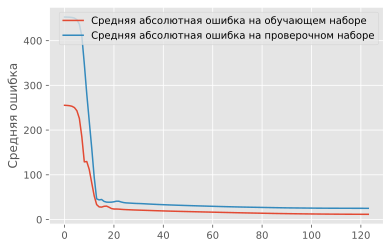

In [11]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    verbose=0
)

plt.plot(history.history['mae'][1:],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [12]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

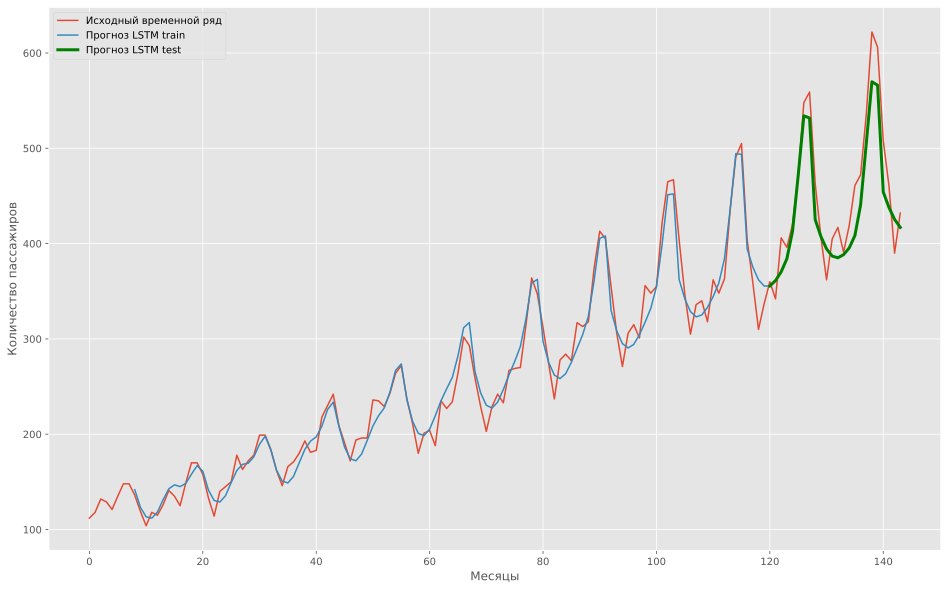

In [13]:
x_pred = np.arange(train_month, 144)
x_pred1 = np.arange(bias, train_month+2)
plt.figure(figsize=(16, 10))
plt.plot(data[target], 
         label='Исходный временной ряд')
plt.plot(x_pred1, pred, 
         label='Прогноз LSTM train')
plt.plot(x_pred, pred_val, linewidth=3,color='g',
         label='Прогноз LSTM test')
plt.xlabel('Месяцы')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

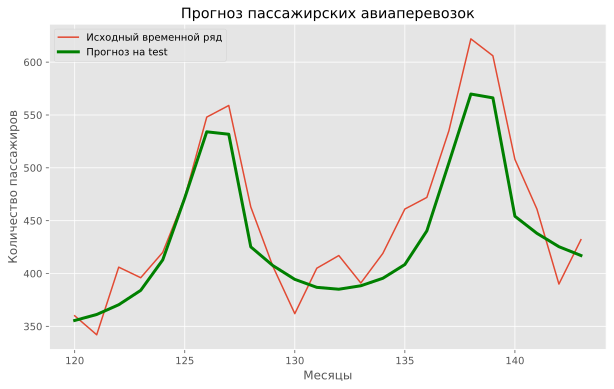

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(data[target][train_month:], 
         label='Исходный временной ряд')
plt.plot(x_pred, pred_val, linewidth=3,color='g',
         label='Прогноз на test')
plt.xlabel('Месяцы')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.title("Прогноз пассажирских авиаперевозок")
plt.show()

In [15]:
mean_absolute_error(data[train_month:][target], pred_val)

25.02273686726888

In [16]:
# качество значительно повысили слои Conv